# relax_liquid - Methodology and code

__Python imports__

- [numpy](http://www.numpy.org/)
- [IPython](https://ipython.org)
- [atomman](https://github.com/usnistgov/atomman)
- [iprPy](https://github.com/usnistgov/iprPy)

In [1]:
# Standard library imports
from pathlib import Path
import shutil
import datetime
from copy import deepcopy
from math import floor
from typing import Optional, Tuple
import random

# http://www.numpy.org/
import numpy as np

# https://ipython.org/
from IPython.display import display, Markdown

import matplotlib.pyplot as plt

# https://github.com/usnistgov/atomman 
import atomman as am
import atomman.lammps as lmp
import atomman.unitconvert as uc
from atomman.tools import filltemplate

# https://github.com/usnistgov/iprPy
import iprPy
from iprPy.tools import read_calc_file

print('Notebook last executed on', datetime.date.today(), 'using iprPy version', iprPy.__version__)

Notebook last executed on 2024-05-06 using iprPy version 0.11.7


## 1. Load calculation and view description

### 1.1. Load the calculation

In [2]:
# Load the calculation being demoed
calculation = iprPy.load_calculation('relax_liquid')

### 1.2. Display calculation description and theory

In [3]:
# Display main docs and theory
display(Markdown(calculation.maindoc))
display(Markdown(calculation.theorydoc))

# relax_liquid calculation style

**Lucas M. Hale**, [lucas.hale@nist.gov](mailto:lucas.hale@nist.gov?Subject=ipr-demo), *Materials Science and Engineering Division, NIST*.

## Introduction

The relax_liquid calculation style is designed to generate and characterize a liquid phase configuration for an atomic potential based on an initial configuration, target temperature and target pressure.  The calculation involves multiple stages of relaxation and computes the mean squared displacement and radial distribution functions on the final liquid.

### Version notes

- 2022-10-12: Calculation created

### Additional dependencies

### Disclaimers

- [NIST disclaimers](http://www.nist.gov/public_affairs/disclaimer.cfm)
- No active checks are performed by this calculation to ensure that the system is liquid. Be sure to check the final atomic configurations. The thermo output can also provide a rough guideline in that you should see convergence of volume but not of the individual lx, ly, lz dimensions for a liquid phase.
- If starting with a crystalline configuration, be sure to use an adequately high melt temperature and number of melt steps.
- The temperature and volume equilibrium stages are designed to get the final nve system close to the target temperature and pressure, but they will not be exact.  Be sure to check that the measured temperature and pressure are close to the targets.


## Method and Theory

This performs five stages of simulations to create and analyze a liquid phase at a given temperature and pressure.

1. A "melt" stage is performed using npt at the target pressure and an elevated melt temperature.
2. A "cooling" stage is performed using npt in which the temperature is linearly reduced from the melt to the target temperature.
3. A "volume equilibrium" stage is performed using npt at the target temperature and pressure.  Following the run, the system's dimensions are equally scaled to the average volume.
4. A "temperature equilibrium" stage is performed using nvt at the target temperature.  Following the run, the atomic velocities are scaled based on the expected total energy at the target temperature.
5. An "nve analysis" stage is performed in which the mean squared displacements of the atoms and the radial distribution function are measured.

### Melt stage

The melt stage subjects the initial configuration to an npt simulation at the elevated melt temperature.  This stage is meant to transform initially crystalline system configurations into amorphous liquid phases.  As such, the melt temperature should be much higher than the melting temperature of the initial crystal, and the number of MD steps during this stage should be sufficiently high to allow for the phase transformation to occur.

If the initial atomic configuration is already amorphous, this stage can be skipped by setting meltsteps = 0.  Also, if the initial configuration already has velocities assigned to the atoms, you can use those velocities by setting createvelocities = False.  These two options make it possible to run a single melt simulation that can be used as the basis for all target temperatures.  Note that createvelocities = True is needed if you want to measure statistical error from multiple runs.

### Cooling stage

The cooling stage runs npt and linearly scales the temperature from the melt temperature to the target temperature.  The larger the number of coolsteps, the more gradual the change from melt to target temperatures will be.  This can be important if the target temperature is much smaller than the melt temperature.

Similarly to the melt stage, this stage can be skipped by setting coolsteps = 0. If meltsteps = coolsteps = 0 and createvelocities = True, the atomic velocities will be created for the system at the target temperature rather than the melt temperature.  This allows for a generic amorphous state to be used as the starting configuration.

### Volume equilibration stage

The volume equilibration stage runs npt at the target temperature and pressure.  It is meant to allow for the system to equilibrate at the target temperature, then to obtain a time-averaged measurement of the system's volume.  The average volume is computed from a specified number of samples (volrelaxsamples) taken every 100 timesteps from the end of this stage.  The max value allowed for volrelaxsamples is volrelaxsteps / 100, but practically it should be noticeably smaller than this to ignore measurements at the beginning of the stage where the system has not yet equilibrated.

When this stage finishes, the volume of the configuration cell is adjusted to the average volume computed by scaling each box length and tilt by the same factor, s

$$ s = \left( \frac{ \left< vol \right> } {vol} \right)^\frac{1}{3} $$

### Temperature equilibration stage

The temperature equilibration stage runs nvt at the target temperature for the system fixed at the computed average volume.  This allows for the system to equilibrate at the fixed volume and target temperature, and to compute a target total energy, $E_{target}$, that corresponds to the system in equilibrium at the target temperature.  $E_{target}$ is computed based on time-averaged energy values from a specified number of samples (temprelaxsamples) taken every 100 timesteps from the end of this stage.  The max value allowed for temprelaxsamples is temprelaxsteps / 100.  Unlike the previous stage, the equilibration portion of this stage is likely negligible, therefore it is less important to ignore the initial measurements.

In LAMMPS, the adjustment is made by scaling all atomic velocities to a temperature $T_s$ such that the current potential energy, $E_{pot}$, plus the kinetic energy for $T_s$ equals $E_{target}$

$$ E_{target} = E_{pot} + \frac{3}{2} N k_B T_s $$
$$ T_s = \frac{2 \left( E_{target} - E_{pot} \right)}{3 N k_B} $$

Two alternate methods for computing $E_{target}$ are implemented and can be accessed with the temprelaxstyle option.

- For temprelaxstyle = 'te', the target total energy is taken as the computed mean total energy
  
$$ E_{target} = \left< E_{total}\right>$$

- For temprelaxstyle = 'pe', the target total energy is taken as the computed mean potential energy plus kinetic energy for the target temperature, $T$

$$ E_{target} = \left< E_{pot} \right> + \frac{3}{2} N k_B T $$

Limited tests show the two methods to result in mean temperatures in the final stage that have roughly the same variation from the target temperature, with 'pe' style giving slightly better results.  As such, both methods are included as options and 'pe' is set as the default.

### Analysis stage

The analysis stage runs nve with the system that has been adjusted to the target volume and total energy from the last two stages.  During this stage, mean squared displacements and radial distribution function calculations are performed that can be used to analyze the liquid phase at the target temperature and pressure.  

In addition to the analysis calculations, the average measured temperature and pressure are reported, which can be used as verification that the volume and temperature equilibration stages and adjustments worked properly.


## 2. Define calculation functions and generate files

This section defines the calculation functions and associated resource files exactly as they exist inside the iprPy package.  This allows for the code used to be directly visible and modifiable by anyone looking to see how it works.

### 2.1. relax_liquid()

This is the primary function for the calculation.  The version of this function built in iprPy can be accessed by calling the calc() method of an object of the associated calculation class.

In [4]:
def relax_liquid(lammps_command: str,
                 system: am.System,
                 potential: lmp.Potential,
                 temperature: float,
                 mpi_command: Optional[str] = None,
                 pressure: float = 0.0,
                 temperature_melt: float = 3000.0,
                 rdfcutoff: Optional[float] = None,
                 meltsteps: int = 50000,
                 coolsteps: int = 10000,
                 equilvolumesteps: int = 50000,
                 equilvolumesamples: int = 300,
                 equilenergysteps: int = 10000,
                 equilenergysamples: int = 100,
                 equilenergystyle: str = 'pe',
                 runsteps: int = 50000,
                 dumpsteps: Optional[int] = None,
                 restartsteps: Optional[int] = None,
                 createvelocities: bool = True,
                 randomseed: Optional[int] = None) -> dict:
    """
    Performs a multi-stage simulation to obtain a liquid phase configuration 
    at a given temperature. Radial displacement functions and mean squared
    displacements are automatically computed for the system.
    
    Parameters
    ----------
    lammps_command :str
        Command for running LAMMPS.
    system : atomman.System
        The system to perform the calculation on.
    potential : atomman.lammps.Potential
        The LAMMPS implemented potential to use.
    temperature : float
        The target temperature to relax to.
    mpi_command : str, optional
        The MPI command for running LAMMPS in parallel.  If not given, LAMMPS
        will run serially.
    pressure : float, optional
        The target hydrostatic pressure to relax to. Default value is 0. GPa.
    temperature_melt : float, optional
        The elevated temperature to first use to hopefully melt the initial
        configuration.
    rdfcutoff : float, optional
        The cutoff distance to use for the RDF cutoff.  If not given then
        will use 4 * r0, where r0 is the shortest atomic distance found in
        the given system configuration.
    meltsteps : int, optional
        The number of npt integration steps to perform during the melting
        stage at the melt temperature to create an amorphous liquid structure.
        Default value is 50000.
    coolsteps : int, optional
        The number of npt integration steps to perform during the cooling
        stage where the temperature is reduced from the melt temperature
        to the target temperature.  Default value is 10000.
    equilvolumesteps : int, optional
        The number of npt integration steps to perform during the volume
        equilibration stage where the system is held at the target temperature
        and pressure to obtain an estimate for the relaxed volume.  Default
        value is 50000.
    equilvolumesamples : int, optional
        The number of thermo samples from the end of the volume equilibration
        stage to use in computing the average volume.  Cannot be larger than
        equilvolumesteps / 100.  It is recommended to set smaller than the max
        to allow for some convergence time.  Default value is 300. 
    equilenergysteps : int, optional
        The number of nvt integration steps to perform during the energy
        equilibration stage where the system is held at the target temperature
        to obtain an estimate for the total energy.  Default value is 10000.
    equilenergysamples : int, optional
        The number of thermo samples from the end of the energy equilibrium
        stage to use in computing the target total energy.  Cannot be
        larger than equilenergysteps / 100.  Default value is 100.
    equilenergystyle : str, optional
        Indicates which scheme to use for computing the target total energy.
        Allowed values are 'pe' or 'te'.  For 'te', the average total energy
        from the equilenergysamples is used as the target energy.  For 'pe',
        the average potential energy plus 3/2 N kB T is used as the target
        energy.  Default value is 'pe'.
    runsteps : int or None, optional
        The number of nve integration steps to perform on the system to
        obtain measurements of MSD and RDF of the liquid. Default value is
        50000.
    dumpsteps : int or None, optional
        Dump files will be saved every this many steps during the runsteps
        simulation. Default is None, which sets dumpsteps equal to the sum of
        all "steps" terms above so that only the final configuration is saved.
    restartsteps : int or None, optional
        Restart files will be saved every this many steps.  Default is None,
        which sets dumpsteps equal to the sum of all "steps" terms above so
        that only the final configuration is saved.
    createvelocities : bool, optional
        If True (default), velocities will be created for the atoms prior to
        running the simulations.  Setting this to False can be useful if the
        initial system already has velocity information.
    randomseed : int or None, optional
        Random number seed used by LAMMPS in creating velocities and with
        the Langevin thermostat.  Default is None which will select a
        random int between 1 and 900000000.
    
    Returns
    -------
    dict
        Dictionary of results consisting of keys:
        
        - **'dumpfile_final'** (*str*) - The name of the final dump file
          created.
        - **'symbols_final'** (*list*) - The symbols associated with the final
          dump file.
        - **'volume'** (*float*) - The volume per atom identified after the volume 
          equilibration stage.
        - **'volume_stderr'** (*float*) - The standard error in the volume per atom
          measured during the volume equilibration stage.
        - **'E_total'** (*float*) - The total energy of the system used during the nve
          stage.
        - **'E_total_stderr'** (*float*) - The standard error in the mean total energy
          computed during the energy equilibration stage.
        - **'E_pot'** (*float*) - The mean measured potential energy during the energy
          equilibration stage.
        - **'E_pot_stderr'** (*float*) - The standard error in the mean potential energy
          during the energy equilibration stage.
        - **'measured_temp'** (*float*) - The mean measured temperature during the nve
          stage.
        - **'measured_temp_stderr'** (*float*) - The standard error in the measured
          temperature values of the nve stage.
        - **'measured_press'** (*float*) - The mean measured pressure during the nve
          stage.
        - **'measured_press_stderr'** (*float*) - The standard error in the measured
          pressure values of the nve stage.
        - **'time_values'** (*numpy.array of float*) - The values of time that
          correspond to the mean squared displacement values.
        - **'msd_x_values'** (*numpy.array of float*) - The mean squared displacement
          values only in the x direction.
        - **'msd_y_values'** (*numpy.array of float*) - The mean squared displacement
          values only in the y direction.
        - **'msd_z_values'** (*numpy.array of float*) - The mean squared displacement
          values only in the z direction.
        - **'msd_values'** (*numpy.array of float*) - The total mean squared
          displacement values.
        - **'lammps_output'** (*atomman.lammps.Log*) - The LAMMPS logfile output.
          Can be useful for checking the thermo data at each simulation stage.
    
    """

    if equilenergystyle not in ['pe', 'te']:
        raise ValueError('invalid equilenergystyle option: must be "pe" or "te"')

    # Get lammps units
    lammps_units = lmp.style.unit(potential.units)

    #Get lammps version date
    lammps_date = lmp.checkversion(lammps_command)['date']
    
    # Handle default values
    if dumpsteps is None:
        dumpsteps = meltsteps + coolsteps + equilvolumesteps + equilenergysteps + runsteps
    if restartsteps is None:
        restartsteps = meltsteps + coolsteps + equilvolumesteps + equilenergysteps + runsteps

    # Check volrelax and temprelax settings
    if equilvolumesamples > equilvolumesteps / 100:
        raise ValueError('invalid values: equilvolumesamples must be <= equilvolumesteps / 100')
    if equilenergysamples > equilenergysteps / 100:
        raise ValueError('invalid values: equilenergysamples must be <= equilenergysteps / 100')

    # Set default rdfcutoff
    if rdfcutoff is None:
        rdfcutoff = 4 * system.r0()

    # Define lammps variables
    lammps_variables = {}

    lammps_variables['boltzmann'] = uc.get_in_units(uc.unit['kB'],
                                                    lammps_units['energy'])

    # Dump initial system as data and build LAMMPS inputs
    system_info = system.dump('atom_data', f='init.dat',
                              potential=potential)
    lammps_variables['atomman_system_pair_info'] = system_info

    # Generate LAMMPS inputs for restarting
    system_info2 = potential.pair_restart_info('*.restart', system.symbols)
    lammps_variables['atomman_pair_restart_info'] = system_info2

    # Phase settings
    lammps_variables['temperature'] = temperature
    lammps_variables['temperature_melt'] = temperature_melt
    lammps_variables['pressure'] = pressure

    # Set timestep dependent parameters
    timestep = lmp.style.timestep(potential.units)
    lammps_variables['timestep'] = timestep
    lammps_variables['temperature_damp'] = 100 * timestep
    lammps_variables['pressure_damp'] = 1000 * timestep

    # Number of run/dump steps
    lammps_variables['meltsteps'] = meltsteps
    lammps_variables['coolsteps'] = coolsteps
    lammps_variables['equilvolumesteps'] = equilvolumesteps
    lammps_variables['equilenergysteps'] = equilenergysteps
    lammps_variables['runsteps'] = runsteps
    lammps_variables['dumpsteps'] = dumpsteps
    lammps_variables['restartsteps'] = restartsteps

    # Number of samples
    lammps_variables['equilvolumesamples'] = equilvolumesamples
    lammps_variables['equilenergysamples'] = equilenergysamples
    
    lammps_variables['rdfcutoff'] = rdfcutoff

    # Set randomseed
    if randomseed is None: 
        randomseed = random.randint(1, 900000000)

    # create velocities 
    if createvelocities:
        if meltsteps == 0 and coolsteps == 0:
            velocity_temp = temperature
        else:
            velocity_temp = temperature_melt
        lammps_variables['create_velocities'] = f'velocity all create {velocity_temp} {randomseed} mom yes rot yes dist gaussian'
    else:
        lammps_variables['create_velocities'] = ''

    # Set dump_keys based on atom_style
    if potential.atom_style in ['charge']:
        lammps_variables['dump_keys'] = 'id type q xu yu zu c_pe vx vy vz'
    else:
        lammps_variables['dump_keys'] = 'id type xu yu zu c_pe vx vy vz'

    # Set dump_modify_format based on lammps_date
    if lammps_date < datetime.date(2016, 8, 3):
        if potential.atom_style in ['charge']:
            lammps_variables['dump_modify_format'] = f'"%d %d{8 * " %.13e"}"'
        else:
            lammps_variables['dump_modify_format'] = f'"%d %d{7 * " %.13e"}"'
    else:
        lammps_variables['dump_modify_format'] = 'float %.13e'

    # Write lammps input script
    lammps_script = 'liquid.in'
    lammps_template = f'liquid_ave_{equilenergystyle}.template'
    template = read_calc_file('iprPy.calculation.relax_liquid', lammps_template)
    with open(lammps_script, 'w', encoding='UTF-8') as f:
        f.write(filltemplate(template, lammps_variables, '<', '>'))

    # Write lammps restart input script
    restart_script = 'liquid_restart.in'
    lammps_template = 'liquid_restart.template'
    template = read_calc_file('iprPy.calculation.relax_liquid', lammps_template)
    with open(restart_script, 'w', encoding='UTF-8') as f:
        f.write(filltemplate(template, lammps_variables, '<', '>'))

    # Fix for restart runs: only use restart script if restart file(s) exist
    if Path('log.lammps').exists() and len(list(Path('.').glob('*.restart'))) == 0:
        Path('log.lammps').unlink()

    # Uniquely rename rdf.txt on restarts to prevent overwrite
    elif Path('rdf.txt').exists():
        maxrdfid = 0
        for oldrdf in Path('.').glob('rdf-*.txt'):
            rdfid = int(oldrdf.stem.split('-')[-1])
            if rdfid > maxrdfid:
                maxrdfid = rdfid
        Path('rdf.txt').rename(f'rdf-{maxrdfid+1}.txt')

    # Run lammps
    output = lmp.run(lammps_command, script_name=lammps_script,
                     restart_script_name=restart_script,
                     mpi_command=mpi_command, screen=False)

    # Extract LAMMPS thermo data.
    run1steps = meltsteps
    run2steps = run1steps + coolsteps
    run3steps = run2steps + equilvolumesteps
    run4steps = run3steps + equilenergysteps
    thermo = output.flatten()['thermo']
    #thermo_melt = thermo[thermo.Step < run1steps]
    #thermo_cool = thermo[(thermo.Step < run2steps) & (thermo.Step >= run1steps)]
    thermo_vol_equil = thermo[(thermo.Step < run3steps) & (thermo.Step >= run2steps)]
    thermo_temp_equil = thermo[(thermo.Step < run4steps) & (thermo.Step >= run3steps)]
    thermo_nve = thermo[thermo.Step >= run4steps]

    results = {}

    # Set final dumpfile info
    last_dump_number = 0
    for dump_file in Path('.').glob('*.dump'):
        dump_number = int(dump_file.name[:-5])
        if dump_number > last_dump_number:
            last_dump_number = dump_number
    last_dump_file = f'{last_dump_number}.dump'
    results['dumpfile_final'] = last_dump_file
    results['symbols_final'] = system.symbols

    natoms = system.natoms

    # Get equilibrated volume 
    volume_unit = f"{lammps_units['length']}^3"
    samplestart = len(thermo_vol_equil) - equilvolumesamples
    results['volume'] = uc.set_in_units(thermo_temp_equil.Volume.values[-1], volume_unit) / natoms
    results['volume_stderr'] = uc.set_in_units(thermo_vol_equil.Volume[samplestart:].std(), volume_unit) / natoms / (equilvolumesamples)**0.5

    # Get equilibrated energies
    samplestart = len(thermo_temp_equil) - equilenergysamples
    results['E_total'] = uc.set_in_units(thermo_nve.TotEng.values[-1], lammps_units['energy']) / natoms
    results['E_total_stderr'] = uc.set_in_units(thermo_temp_equil.TotEng[samplestart:].std(), lammps_units['energy']) / natoms / (equilenergysamples)**0.5
    results['E_pot'] = uc.set_in_units(thermo_temp_equil.PotEng[samplestart:].mean(), lammps_units['energy']) / natoms
    results['E_pot_stderr'] = uc.set_in_units(thermo_temp_equil.PotEng[samplestart:].std(), lammps_units['energy']) / natoms / (equilenergysamples)**0.5

    # Get measured temperature and pressure during the nve run
    nsamples = len(thermo_nve)
    results['measured_temp'] = thermo_nve.Temp.values.mean()
    results['measured_temp_stderr'] = thermo_nve.Temp.values.std() / (nsamples)**0.5
    pressure = (thermo_nve.Pxx.values + thermo_nve.Pyy.values + thermo_nve.Pzz.values) / 3
    results['measured_press'] = uc.set_in_units(pressure.mean(), lammps_units['pressure'])
    results['measured_press_stderr'] = uc.set_in_units(pressure.std(), lammps_units['pressure']) / (nsamples)**0.5

    # Get MSD values
    msd_unit = f"{lammps_units['length']}^2"
    time = (thermo_nve.Step.values - thermo_nve.Step.values[0]) * timestep
    results['time_values'] = uc.set_in_units(time, lammps_units['time'])
    results['msd_x_values'] = uc.set_in_units(thermo_nve['c_msd[1]'].values, msd_unit)
    results['msd_y_values'] = uc.set_in_units(thermo_nve['c_msd[2]'].values, msd_unit)
    results['msd_z_values'] = uc.set_in_units(thermo_nve['c_msd[3]'].values, msd_unit)
    results['msd_values'] = uc.set_in_units(thermo_nve['c_msd[4]'].values, msd_unit)

    results['lammps_output'] = output

    return results

### 2.2. liquid_ave_pe.template file

In [5]:
with open('liquid_ave_pe.template', 'w') as f:
    f.write("""# LAMMPS input script that performs a liquid phase relaxation and evaluation

box tilt large

<atomman_system_pair_info>

change_box all triclinic

timestep <timestep>

# Define variables for box volume
variable vol equal vol
fix ave_vol all ave/time 100 1 100 v_vol ave window <equilvolumesamples>
variable ave_vol equal f_ave_vol

# Define thermo for relax stages
thermo 100
thermo_style custom step temp pe ke etotal pxx pyy pzz lx ly lz vol f_ave_vol
thermo_modify format float %.13e

<create_velocities>

################################## Melt ############################

fix npt all npt temp <temperature_melt> <temperature_melt> <temperature_damp> aniso <pressure> <pressure> <pressure_damp>
run <meltsteps>
unfix npt

######################### Scale to temperature ####################

fix npt all npt temp <temperature_melt> <temperature> <temperature_damp> aniso <pressure> <pressure> <pressure_damp>
run <coolsteps>
unfix npt

####################### Equilibrate volume #######################

fix npt all npt temp <temperature> <temperature> <temperature_damp> aniso <pressure> <pressure> <pressure_damp>
run <equilvolumesteps>
unfix npt

# Scale box dimensions according to last computed average volume
variable scale equal (${ave_vol}/${vol})^(1/3)
variable slx equal ${scale}*lx
variable sly equal ${scale}*ly
variable slz equal ${scale}*lz
variable sxy equal ${scale}*xy
variable sxz equal ${scale}*xz
variable syz equal ${scale}*yz
change_box all x final 0.0 ${slx} y final 0.0 ${sly} z final 0.0 ${slz} xy final ${sxy} xz final ${sxz} yz final ${syz} remap units box

####################### Equilibrate energy #######################

# Compute average potential energy over the nvt run
variable pe equal pe
fix ave_pe all ave/time 100 1 100 v_pe ave window <equilenergysamples>

# Perform an nvt run at target dimensions
fix nvt all nvt temp <temperature> <temperature> <temperature_damp>
run <equilenergysteps>
unfix nvt

# Compute temperature to scale velocities to achieve target etotal
variable kB equal <boltzmann>
variable etotal_scale equal f_ave_pe+(3/2)*atoms*v_kB*<temperature>
variable temperature_scale equal 2*(v_etotal_scale-pe)/(3*atoms*v_kB)

# Scale last velocities to temperature_scale
print "Scaling to target etotal using temperature = ${temperature_scale}"
velocity all scale ${temperature_scale}
unfix ave_pe

###################### NVE analysis run ########################

# Set up analysis computes
compute pe all pe/atom
compute msd all msd com yes
compute rdf all rdf 200 cutoff <rdfcutoff>
fix 1 all ave/time 100 1 100 c_rdf[*] file rdf.txt mode vector

variable ghostcutoff equal <rdfcutoff>+2.01
comm_modify cutoff ${ghostcutoff}

# Dump configurations
dump dumpit all custom <dumpsteps> *.dump <dump_keys>
dump_modify dumpit format <dump_modify_format>
restart <restartsteps> *.restart

# Change thermo to report msd
thermo 100
thermo_style custom step temp pe ke etotal pxx pyy pzz c_msd[1] c_msd[2] c_msd[3] c_msd[4]
thermo_modify format float %.13e

fix nve all nve
run <runsteps>""")

### 2.3. liquid_ave_te.template file

In [6]:
with open('liquid_ave_te.template', 'w') as f:
    f.write("""# LAMMPS input script that performs a liquid phase relaxation and evaluation

box tilt large

<atomman_system_pair_info>

change_box all triclinic

timestep <timestep>

# Define variables for box volume
variable vol equal vol
fix ave_vol all ave/time 100 1 100 v_vol ave window <equilvolumesamples>
variable ave_vol equal f_ave_vol

# Define thermo for relax stages
thermo 100
thermo_style custom step temp pe ke etotal pxx pyy pzz lx ly lz vol f_ave_vol
thermo_modify format float %.13e

<create_velocities>

################################## Melt ############################

fix npt all npt temp <temperature_melt> <temperature_melt> <temperature_damp> aniso <pressure> <pressure> <pressure_damp>
run <meltsteps>
unfix npt

######################### Scale to temperature ####################

fix npt all npt temp <temperature_melt> <temperature> <temperature_damp> aniso <pressure> <pressure> <pressure_damp>
run <coolsteps>
unfix npt

####################### Equilibrate volume #######################

fix npt all npt temp <temperature> <temperature> <temperature_damp> aniso <pressure> <pressure> <pressure_damp>
run <equilvolumesteps>
unfix npt

# Scale box dimensions according to last computed average volume
variable scale equal (${ave_vol}/${vol})^(1/3)
variable slx equal ${scale}*lx
variable sly equal ${scale}*ly
variable slz equal ${scale}*lz
variable sxy equal ${scale}*xy
variable sxz equal ${scale}*xz
variable syz equal ${scale}*yz
change_box all x final 0.0 ${slx} y final 0.0 ${sly} z final 0.0 ${slz} xy final ${sxy} xz final ${sxz} yz final ${syz} remap units box

####################### Equilibrate energy #######################

# Compute average total energy over the nvt run
variable etotal equal etotal
fix ave_etotal all ave/time 100 1 100 v_etotal ave window <equilenergysamples>

# Perform an nvt run at target dimensions
fix nvt all nvt temp <temperature> <temperature> <temperature_damp>
run <equilenergysteps>
unfix nvt

# Compute temperature to scale velocities to achieve target etotal
variable kB equal <boltzmann>
variable temperature_scale equal 2*(f_ave_etotal-pe)/(3*atoms*v_kB)

# Scale last velocities to temperature_scale
print "Scaling to target etotal using temperature = ${temperature_scale}"
velocity all scale ${temperature_scale}
unfix ave_etotal

###################### NVE analysis run ########################

# Set up analysis computes
compute pe all pe/atom
compute msd all msd com yes
compute rdf all rdf 200 cutoff <rdfcutoff>
fix 1 all ave/time 100 1 100 c_rdf[*] file rdf.txt mode vector

variable ghostcutoff equal <rdfcutoff>+2.01
comm_modify cutoff ${ghostcutoff}

# Dump configurations
dump dumpit all custom <dumpsteps> *.dump <dump_keys>
dump_modify dumpit format <dump_modify_format>
restart <restartsteps> *.restart

# Change thermo to report msd
thermo 100
thermo_style custom step temp pe ke etotal pxx pyy pzz c_msd[1] c_msd[2] c_msd[3] c_msd[4]
thermo_modify format float %.13e

fix nve all nve
run <runsteps>""")

In [7]:
with open('liquid_restart.template', 'w') as f:
    f.write("""# LAMMPS input script that performs a liquid phase relaxation and evaluation

# Cumulative run steps
variable maxstep equal <meltsteps>+<coolsteps>+<equilvolumesteps>+<equilenergysteps>+<runsteps>

box tilt large

<atomman_pair_restart_info>

###################### NVE analysis run ########################

# Set up analysis computes
compute pe all pe/atom
compute msd all msd com yes
compute rdf all rdf 200 cutoff <rdfcutoff>
fix 1 all ave/time 100 1 100 c_rdf[*] file rdf.txt mode vector

variable ghostcutoff equal <rdfcutoff>+2.01
comm_modify cutoff ${ghostcutoff}

# Dump configurations
dump dumpit all custom <dumpsteps> *.dump <dump_keys>
dump_modify dumpit format <dump_modify_format>
restart <restartsteps> *.restart

# Change thermo to report msd
thermo 100
thermo_style custom step temp pe ke etotal pxx pyy pzz c_msd[1] c_msd[2] c_msd[3] c_msd[4]
thermo_modify format float %.13e

fix nve all nve
run ${maxstep} upto""")

## 3. Specify input parameters

### 3.1. System-specific paths

- __lammps_command__ is the LAMMPS command to use (required).
- __mpi_command__ MPI command for running LAMMPS in parallel. A value of None will run simulations serially.


In [8]:
lammps_command = '/home/lmh1/LAMMPS/2022-06-23/src/lmp_mpi'
mpi_command = 'mpiexec -n 8'

# Optional: check that LAMMPS works and show its version 
print(f'LAMMPS version = {am.lammps.checkversion(lammps_command)["version"]}')

LAMMPS version = 23 Jun 2022


### 3.2. Interatomic potential

- __potential_name__ gives the name of the potential_LAMMPS reference record in the iprPy library to use for the calculation.  
- __potential__ is an atomman.lammps.Potential object (required).


In [9]:
potential_name = '1999--Mishin-Y--Ni--LAMMPS--ipr1'

# Retrieve potential and parameter file(s) using atomman
potential = am.load_lammps_potential(id=potential_name, getfiles=True)

### 3.3. Initial unit cell system

- __ucell__ is an atomman.System representing a fundamental unit cell of the system (required).  Here, this is generated using the load parameters and symbols.


In [10]:
# Create ucell by loading prototype record
ucell = am.load('prototype', 'A1--Cu--fcc', symbols='Ni', a=3.5)

print(ucell)

avect =  [ 3.500,  0.000,  0.000]
bvect =  [ 0.000,  3.500,  0.000]
cvect =  [ 0.000,  0.000,  3.500]
origin = [ 0.000,  0.000,  0.000]
natoms = 4
natypes = 1
symbols = ('Ni',)
pbc = [ True  True  True]
per-atom properties = ['atype', 'pos']
     id |   atype |  pos[0] |  pos[1] |  pos[2]
      0 |       1 |   0.000 |   0.000 |   0.000
      1 |       1 |   0.000 |   1.750 |   1.750
      2 |       1 |   1.750 |   0.000 |   1.750
      3 |       1 |   1.750 |   1.750 |   0.000


### 3.4. System modifications

- __sizemults__ list of three integers specifying how many times the ucell vectors of $a$, $b$ and $c$ are replicated in creating system.

- __system__ is an atomman.System to perform the scan on (required). 

In [11]:
sizemults = [10, 10, 10]

# Generate system by supersizing ucell
system = ucell.supersize(*sizemults)
print('# of atoms in system =', system.natoms)

# of atoms in system = 4000


### 3.5. Calculation-specific parameters

- __pressure__ gives the hydrostatic pressure to equilibriate the system to.
- __temperature__ gives the temperature to equilibriate the system to.
- __temperature_melt__ gives the temperature to use during the melt stage.
- __rdfcutoff__ gives tThe cutoff distance to use for the RDF cutoff.  If not given the   will use 4 * r0, where r0 is the shortest atomic distance found     the given system configurati  Included here to support potentials that require a much larger cutoff.on.
- __meltsteps__ gives the number of MD steps to perform during the melt stage.
- __coolsteps__ gives the number of MD steps to perform during the cooling stage.
- __equilvolumesteps__ gives the number of MD steps to perform during the volume equilibration stage.
- __equilvolumesamples__ gives the number of thermo samples to use in estimating the average volume during the volume equilibration phase.  Must be <= volrelaxsteps / 100.
- __equilenergysteps__ gives the number of MD steps to perform during the temperature equilibration stage.
- __equilenergysamples__ gives the number of thermo samples to use in estimating the average potential energy during the temperature equilibration phase.  Must be <= temprelaxsteps / 100.
- __equilenergystyle__ specifies the method to use for evaluating the average energy: 'pe' or 'te'.  For 'te', the average total energy  from the equilenergysamples is used as the target energy.  For 'pe'   the average potential energy plus 3/2 N kB T is used as the targ    energy.  Default value is 'pe'.
- __runsteps__ gives the number of MD steps to perform during the nve analysis stage.
- __dumpsteps__ gives the number of MD steps that atomic configurations are to be dumped during the nve analysis stage.  If None, will be set to runste
- __restartsteps__ gives the number of MD steps that restart files are to be dumped during the nve analysis stage.  If None, will be set to runsteps.ps.
- __createvelocities__ indicates if atomic velocities will be created for all atoms before any of the simulations.  Only set to False if the system already has atomic velocities and you wish to use those. 
- __randomseed__ gives an integer random number generator seed.  Setting this to None will randomly pick a number.

In [12]:
pressure = uc.set_in_units(0.0, 'GPa')
temperature = 2000.0
temperature_melt = 3000.0
rdfcutoff = None
meltsteps = 50000
coolsteps = 10000
equilvolumesteps = 50000
equilvolumesamples = 300
equilenergysteps = 10000
equilenergysamples = 100
equilenergystyle = 'pe'
runsteps = 50000
dumpsteps = None
restartsteps = None
createvelocities = True
randomseed = None

## 4. Run calculation and view results

### 4.1. Run calculation

All primary calculation method functions take a series of inputs and return a dictionary of outputs.

In [13]:
results_dict = relax_liquid(lammps_command, system, potential, temperature,
                            mpi_command = mpi_command,
                            pressure = pressure,
                            temperature_melt = temperature_melt,
                            rdfcutoff = rdfcutoff,
                            meltsteps = meltsteps,
                            coolsteps = coolsteps,
                            equilvolumesteps = equilvolumesteps,
                            equilvolumesamples = equilvolumesamples,
                            equilenergysteps = equilenergysteps,
                            equilenergysamples = equilenergysamples,
                            equilenergystyle = equilenergystyle,
                            runsteps = runsteps,
                            dumpsteps = dumpsteps,
                            restartsteps = restartsteps,
                            createvelocities = createvelocities,
                            randomseed = randomseed)
print(results_dict.keys())

dict_keys(['dumpfile_final', 'symbols_final', 'volume', 'volume_stderr', 'E_total', 'E_total_stderr', 'E_pot', 'E_pot_stderr', 'measured_temp', 'measured_temp_stderr', 'measured_press', 'measured_press_stderr', 'time_values', 'msd_x_values', 'msd_y_values', 'msd_z_values', 'msd_values', 'lammps_output'])


### 4.2. Report results

Values returned in the results_dict:
  
- **'dumpfile_final'** (*str*) - The name of the final dump file
  created.
- **'symbols_final'** (*list*) - The symbols associated with the final
  dump file.
- **'volume'** (*float*) - The mean volume per atom measured for the liquid.
- **'volume_stderr'** (*float*) - The standard error in the volume per atom
  measured during the npt run at the target temperature.
- **'measured_temp'** (*float*) - The mean measured temperature during the nve
  run.
- **'measured_temp_stderr'** (*float*) - The standard error in the measured
  temperature values of the nve run.
- **'measured_press'** (*float*) - The mean measured pressure during the nve
  run.
- **'measured_press_stderr'** (*float*) - The standard error in the measured
  pressure values of the nve run.
- **'time_values'** (*numpy.array of float*) - The values of time that
  correspond to the mean squared displacement values.
- **'msd_x_values'** (*numpy.array of float*) - The mean squared displacement
  values only in the x direction.
- **'msd_y_values'** (*numpy.array of float*) - The mean squared displacement
 values only in the y direction.
- **'msd_z_values'** (*numpy.array of float*) - The mean squared displacement
 values only in the z direction.
- **'msd_values'** (*numpy.array of float*) - The total mean squared
  displacement values.
- **'vacf_values'** (*numpy.array of float*) - The computed velocity auto
  correlation function values for each recorded timestep.
- **'diff_values'** (*numpy.array of float*) - The estimated diffusion constant
  obtained by integrating all vacf values up to the associated timestep.
- **'lammps_output'** (*atomman.lammps.Log*) - The LAMMPS logfile output.
  Can be useful for checking the thermo data at each simulation stage.

#### 4.2.1. Final configuration is saved in the following file

In [14]:
print('final dump file:', results_dict['dumpfile_final'])
print('use symbols:', results_dict['symbols_final'])

final dump file: 170000.dump
use symbols: ('Ni',)


#### 4.2.2. Show the measured phase state and standard errors computed during the volume equilibration and nve stages.

In [15]:
length_unit = 'angstrom'
pressure_unit = 'GPa'
volume_unit = f'{length_unit}^3'

print('The measured phase state:')
print('volume / atom =', uc.get_in_units(results_dict['volume'], volume_unit),
      '+-', uc.get_in_units(results_dict['volume_stderr'], volume_unit), volume_unit)
print('temperature =', results_dict['measured_temp'], '+-', results_dict['measured_temp_stderr'], 'K')
print('pressure =', uc.get_in_units(results_dict['measured_press'], pressure_unit),
      '+-', uc.get_in_units(results_dict['measured_press_stderr'], pressure_unit), pressure_unit)

The measured phase state:
volume / atom = 12.5385157311685 +- 0.001849252443812218 angstrom^3
temperature = 1999.4867380415828 +- 0.8714919187515953 K
pressure = -0.03052734301591043 +- 0.005278111721774414 GPa


#### 4.2.3. Show the energy estimates and standard errors computed during the energy equilibration stage.

In [16]:
energy_unit = 'eV'

print('E_total / atom =', uc.get_in_units(results_dict['E_total'], energy_unit),
      '+-', uc.get_in_units(results_dict['E_total_stderr'], energy_unit), energy_unit)
print('E_pot / atom =', uc.get_in_units(results_dict['E_pot'], energy_unit),
      '+-', uc.get_in_units(results_dict['E_pot_stderr'], energy_unit), energy_unit)

E_total / atom = -3.6809218750865003 +- 0.0005054189509131077 eV
E_pot / atom = -3.9393796679502655 +- 0.0003547773125428261 eV


#### 4.2.4. Plot mean squared displacement

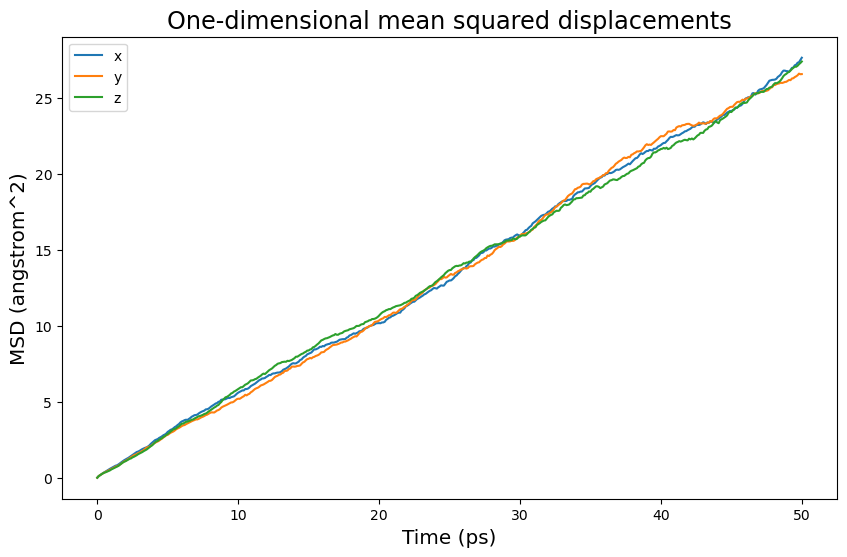

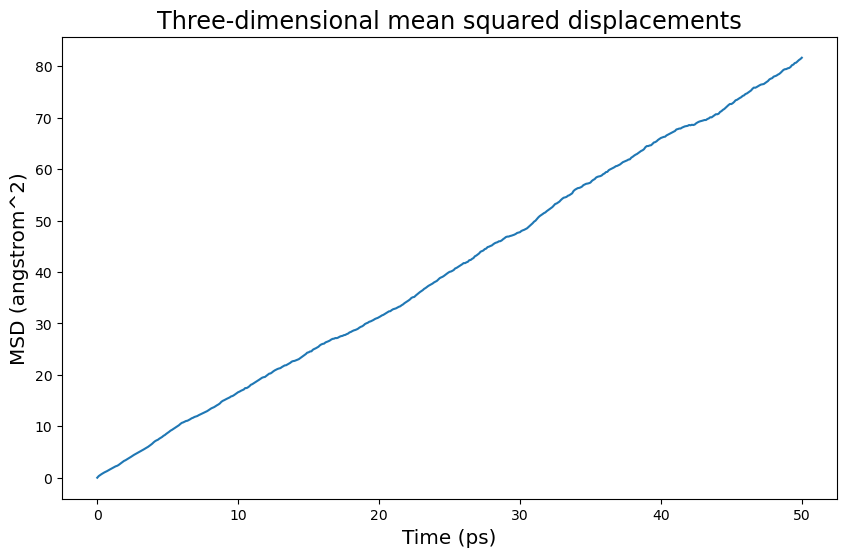

In [17]:
area_unit = f'{length_unit}^2'
time_unit = 'ps'


time = uc.get_in_units(results_dict['time_values'], time_unit)
msd_x = uc.get_in_units(results_dict['msd_x_values'], area_unit)
msd_y = uc.get_in_units(results_dict['msd_y_values'], area_unit)
msd_z = uc.get_in_units(results_dict['msd_z_values'], area_unit)
msd = uc.get_in_units(results_dict['msd_values'], area_unit)

fig = plt.figure(figsize=(10,6))
plt.title('One-dimensional mean squared displacements', size='xx-large')
plt.xlabel(f'Time ({time_unit})', size='x-large')
plt.ylabel(f'MSD ({area_unit})', size='x-large')
plt.plot(time, msd_x, label='x')
plt.plot(time, msd_y, label='y')
plt.plot(time, msd_z, label='z')
plt.legend()
plt.show()

fig = plt.figure(figsize=(10,6))
plt.title('Three-dimensional mean squared displacements', size='xx-large')
plt.xlabel(f'Time ({time_unit})', size='x-large')
plt.ylabel(f'MSD ({area_unit})', size='x-large')
plt.plot(time, msd)
plt.show()

#### 4.2.5. Estimate the diffusion constant

In [18]:
diff_unit = f'{area_unit}/{time_unit}'

# Estimate diffusion coefficient from MSD
start = 100
D_msd = np.polyfit(time[start:], msd[start:], 1)[0]
print(f'D estimate from MSD = {D_msd} {area_unit}/{time_unit}')

D estimate from MSD = 1.6421355455960973 angstrom^2/ps


### 4.3. Plot radial distribution function

Radial distribution results are saved to the file rdf.txt.  This can be read in and quickly plotted and analyzed with the atomman.thermo.RDF class.

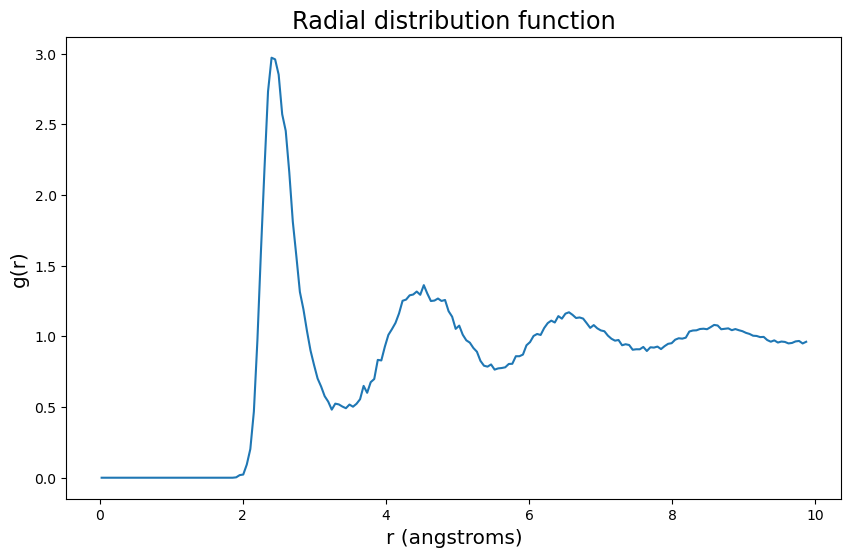

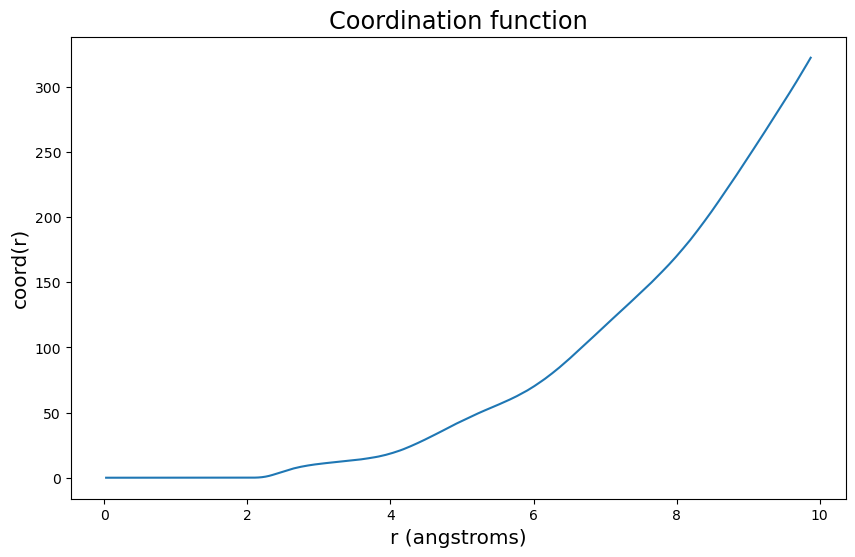

In [19]:
rdf = am.thermo.RDF(lammps_rdf_file='rdf.txt')

fig = plt.figure(figsize=(10,6))
plt.title('Radial distribution function', size='xx-large')
plt.xlabel('r (angstroms)', size='x-large')
plt.ylabel('g(r)', size='x-large')
plt.plot(rdf.r, rdf.g)
plt.show()
    
fig = plt.figure(figsize=(10,6))
plt.title('Coordination function', size='xx-large')
plt.xlabel('r (angstroms)', size='x-large')
plt.ylabel('coord(r)', size='x-large')
plt.plot(rdf.r, rdf.coord)
plt.show()

### 4.4. Look at simulation thermo results in the log.lammps file

This is a complex calculation with many components.  It can be useful to check the reported thermo values of some of the earlier stages to ensure that the individual stages behaved properly.

In [20]:
# The log content can be directly accessed when the calculation is done in a Python environment
log = results_dict['lammps_output']

# Or, read the info in from the log file...
#log = am.lammps.Log('log.lammps')

#### 4.4.1. Check Melt stage

A quick check of volume and box dimensions during the melt stage can help reveal if the system has transformed into a liquid.

- The measured volume should converge to a constant value.
- The measured box dimensions should *not* converge to constant values.

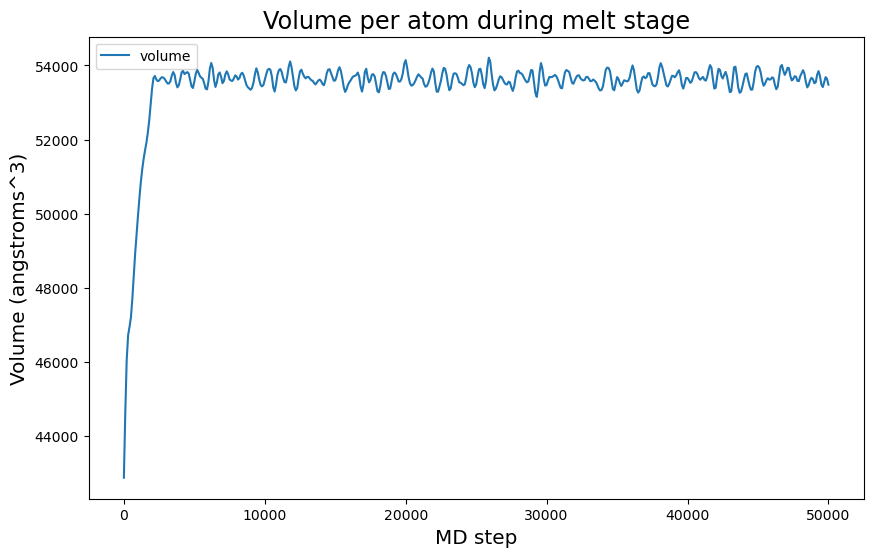

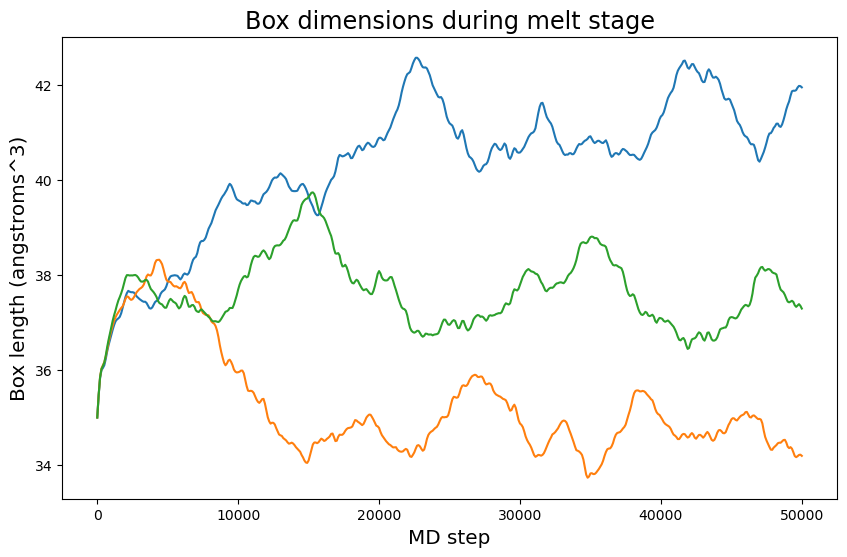

In [21]:
fig = plt.figure(figsize=(10,6))
plt.title('Volume per atom during melt stage', size='xx-large')
plt.xlabel('MD step', size='x-large')
plt.ylabel('Volume (angstroms^3)', size='x-large')
plt.plot(log.simulations[0].thermo.Step, log.simulations[0].thermo.Volume, label='volume')
plt.legend()
plt.show()

fig = plt.figure(figsize=(10,6))
plt.title('Box dimensions during melt stage', size='xx-large')
plt.xlabel('MD step', size='x-large')
plt.ylabel('Box length (angstroms^3)', size='x-large')
plt.plot(log.simulations[0].thermo.Step, log.simulations[0].thermo.Lx, label='lx')
plt.plot(log.simulations[0].thermo.Step, log.simulations[0].thermo.Ly, label='ly')
plt.plot(log.simulations[0].thermo.Step, log.simulations[0].thermo.Lz, label='lz')
plt.show()

#### 4.4.2. Volume equilibration stage

Also important is to check that the measured volume and time averaged volumes are converging appropriately for the volume equilibration stage.  Note that only the last time-averaged value is used to adjust the system dimensions.

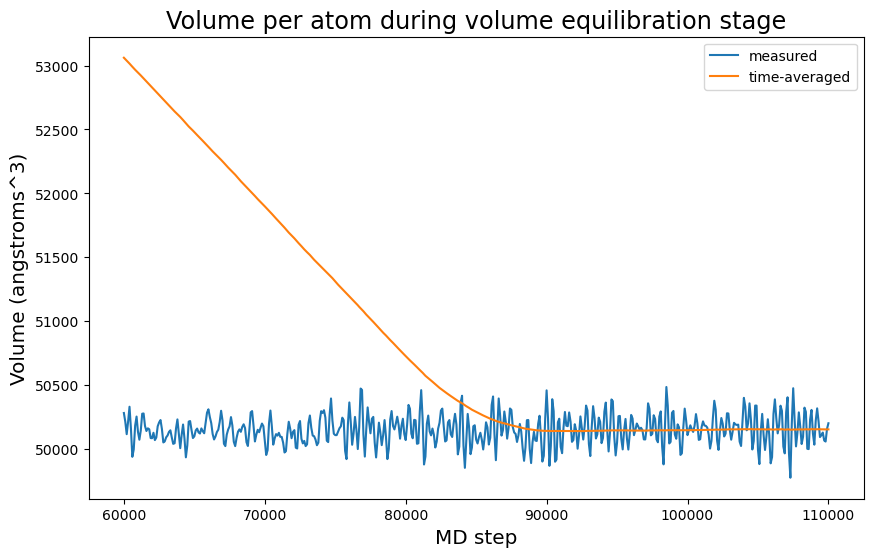

In [22]:
# Plot volume and average volume during the volume equilibrate stage to check convergence
fig = plt.figure(figsize=(10,6))

plt.title('Volume per atom during volume equilibration stage', size='xx-large')
plt.xlabel('MD step', size='x-large')
plt.ylabel('Volume (angstroms^3)', size='x-large')
plt.plot(log.simulations[2].thermo.Step, log.simulations[2].thermo.Volume, label='measured')
plt.plot(log.simulations[2].thermo.Step, log.simulations[2].thermo.f_ave_vol, label='time-averaged')
plt.legend()
plt.show()